In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import random
import mpl_toolkits.mplot3d.axes3d as p3
from scipy import interpolate
%matplotlib widget

In [2]:
def rand_generator(Nmin, Nmax, dim, tmax, n_t):
    '''
    This function generates random trajectories for a random number of particles between Nmin and Nmax in a given dimension and a given timeframe.
    
    Parameters
    -----------------------------
    Nmin
        Minimum number of bodies
    Nmax
        Maximum number of bodies
    dim
        Dimension of the Nbody simulation
    tmax
        Maximum time
    n_t
        Number of stime steps
    
    Output
    -----------------------------
    Creates a txt file with random positions of n particle with Nmin < n < Nmax.
    '''
    # generate a random number of particels bewteen 3 and 100
    n = random.randint(Nmin,Nmax)
    # create n random coordinates
    pos_0 = np.random.rand(n,dim)*100
    # define certain timesteps at which the position is 'calculated'
    timestep = np.linspace(0, tmax, n_t)
    # create random trajectories for the particles
    pos = np.ndarray((n_t, n, dim))
    pos[0]=pos_0
    for i in range(n_t-1):
        d_pos = np.random.rand(n,dim)
        pos[i+1] = pos[i] + d_pos

    # a text document with the timestep and x, y, z positions for each particle
    with open('testpos_{}D.txt'.format(dim), 'w') as d:
        for t in range(101):
            d.write(str(timestep[t]) + ' ')
            for i in range(n):
                for j in range(dim):
                    d.write(str(pos[t][i][j])+ ' ')
            d.write('\n')

# Please ignore this block.

The code in this block has been used to generate random trajectories for a random number of particles. To avoid generating new trajectories this has been converted to Markdown mode but can be converted back to code to test for new trajectories.

``
rand_generator(3, 100, 2, 100, 101)
``
``
rand_generator(3, 100, 3, 100, 101)
``



In [3]:
def trajectories(file, dim):
    """
    This function takes a txt file where the lines contains the timesteps and the positions of the N partilces at that timestep and gives the timesteps and a numpy array with the coordinates of each particle at a timestep.
    
    Parameters
    -----------------------------
    file
        The txt file containing the times teps and positions
        The input needs to have the form: t  x_1  y_1  z_1 ... x_N  y_N  z_N
    dim
        Dimension of the Nbody simulation
    
    Output
    -----------------------------
    t
        An array containing the timesteps
    ind_traj
        An array defining the traject of the N particles.
        The output ind_traj has the form [pos_0, ..., pos_t] with pos_i=[[x_0i, y_0i, z_0i], ..., [x_Ni, y_Ni, z_Ni]]
    """
    traj = np.loadtxt('{}.txt'.format(file))
    # get the number of particles and timesteps
    N = int((len(traj[0]) - 1)/dim)
    n_t = len(traj)
    # getting the timesteps
    t=np.zeros(n_t)
    # an arry with the trajectories of the N particles
    ind_traj = np.zeros((n_t, N, dim))
    for i in range(n_t):
        t[i] = traj[i][0]
        part_traj = np.split(traj[i][1:], N)
        for j in range(N):
            ind_traj[i][j]= part_traj[j]
    return t, ind_traj

In [4]:
def animate(file, dim, name='animation', lim= None, dpi=300):
    """
    This function takes a txt file where the lines contains the timesteps and the positions of the N partilces at that timestep and animates the trajectories of the particles.
    
    Parameters
    -----------------------------
    file
        The txt file containing the times teps and positions
        The input needs to have the form: t  x_1  y_1  z_1 ... x_N  y_N  z_N
    dim
        Dimension of the Nbody simulation, has to be 2 or 3
    name
        Name of the animation file
    lim
        An array with the axis limits
    dpi
        DPI of the animation
    
    Output
    -----------------------------
    Creates an mkv file a animating the trajectories of the N particles.
    """
    t, traj = trajectories(file, dim)
    n_t = len(traj)
    N = len(traj[0])
    def update_2(i):
        for j in range(N):
            scatters[j].set_offsets([traj[i][j][0], traj[i][j][1]])
        return scatters

    def update_3(i):
        for j in range(N):
            scatters[j]._offsets3d=(traj[i][j,0:1], traj[i][j,1:2], traj[i][j,2:])
        return scatters

    fig = plt.figure()
    # TODO: add a time slider
    if dim == 2:
        ax = fig.add_subplot(111)
        ax.set_title('N={}'.format(N))
        if lim:
            ax.set_xlim(lim[0][0], lim[0][1])
            ax.set_ylim(lim[1][0], lim[1][1])
        ax.grid(False)
        scatters = [ax.scatter(traj[0][i][0], traj[0][i][1], s=2) for i in range(N)]
        ani = animation.FuncAnimation(fig, update_2, frames=n_t)
        ani.save('ani_traj/{}_2D.mkv'.format(name), fps=30, dpi=dpi)

    if dim == 3:
        ax = fig.add_subplot(projection='3d')
        ax.set_title('N={}'.format(N))
        if lim:
            ax.set_xlim3d(lim[0][0], lim[0][1])
            ax.set_ylim3d(lim[1][0], lim[1][1])
            ax.set_zlim3d(lim[2][0], lim[2][1])
        ax.grid(False)
        scatters = [ax.scatter(traj[0][i][0], traj[0][i][1], traj[0][i][2], s=2) for i in range(N)]
        ani = animation.FuncAnimation(fig, update_3, frames=n_t)
        ani.save('ani_traj/{}_3D.mkv'.format(name), fps=30, dpi=dpi)
    plt.show()

In [5]:
def animate_inter(file, dim, tstep_per_sec, line=False, name='animation', dpi=300):
    """
    This function takes a txt file where the lines contains the timesteps and the positions of the N partilces at that timestep and animates the trajectories of the particles. This is a slight modification of the original progam and allows to animate trajectories with non uniform timesteps correctly.
    
    Parameters
    -----------------------------
    file
        The txt file containing the times teps and positions
        The input needs to have the form: t  x_1  y_1  z_1 ... x_N  y_N  z_N
    dim
        Dimension of the Nbody simulation, has to be 2 or 3
    tstep
        The timescale of the simulation, or in other words how much should one second of video be equal to the time used in simulation
    line
        Whether or not to plot the lines
    name
        Name of the animation file
    dpi
        DPI of the animation
    
    Output
    -----------------------------
    Creates an mkv file a animating the trajectories of the N particles.
    """
    t, traj_org = trajectories(file, dim)
    n_t_org = len(traj_org)
    t_max = t[-1]
    tstep_per_frame = tstep_per_sec/30
    time = np.arange(0, t_max, step=tstep_per_frame)
    f = interpolate.interp1d(t, traj_org, axis=0)
    traj = f(time)
    n_t = len(traj)
    N = len(traj[0])
    
    def update_2(i):
        for j in range(N):
            scatters[j].set_offsets([traj[i][j][0], traj[i][j][1]])
        return scatters

    def update_3(i):
        for j in range(N):
            scatters[j]._offsets3d=(traj[i][j,0:1], traj[i][j,1:2], traj[i][j,2:])
        return scatters

    plt.style.use('dark_background')
    fig = plt.figure()
    # TODO: add a time slider
    if dim == 2:
        ax = fig.add_subplot(111)
        ax.set_title('N={}'.format(N))
        x_all = np.array([traj[i][:,0] for i in range(n_t)]).flatten()
        y_all = np.array([traj[i][:,1] for i in range(n_t)]).flatten()
        ax.set_xlim(x_all.min(), x_all.max())
        ax.set_ylim(y_all.min(), y_all.max())
        ax.grid(False)
        scatters = [ax.scatter(traj[0][i][0], traj[0][i][1], s=2) for i in range(N)]
        if line:
            x = np.zeros((N, n_t_org))
            y = np.zeros((N, n_t_org))
            for i in range(N):
                for j in range(n_t_org):
                    x[i][j] = traj_org[j][i][0]
                    y[i][j] = traj_org[j][i][1]
            for i in range(N):
                ax.plot(x[i],y[i], linestyle='dotted', linewidth=0.3)
        ani = animation.FuncAnimation(fig, update_2, frames=n_t)
        ani.save('{}_2D.mkv'.format(name), fps=30, dpi=dpi)

    if dim == 3:
        ax = fig.add_subplot(projection='3d')
        ax.set_title('N={}'.format(N))
        x_all = np.array([traj[i][:,0] for i in range(n_t)]).flatten()
        y_all = np.array([traj[i][:,1] for i in range(n_t)]).flatten()
        z_all = np.array([traj[i][:,2] for i in range(n_t)]).flatten()
        ax.set_xlim3d(x_all.min(), x_all.max())
        ax.set_ylim3d(y_all.min(), y_all.max())
        ax.set_zlim3d(z_all.min(), z_all.max())
        ax.grid(False)
        scatters = [ax.scatter(traj[0][i][0], traj[0][i][1], traj[0][i][2], s=2) for i in range(N)]
        if line:
            x = np.zeros((N, n_t_org))
            y = np.zeros((N, n_t_org))
            z = np.zeros((N, n_t_org))
            for i in range(N):
                for j in range(n_t_org):
                    x[i][j] = traj_org[j][i][0]
                    y[i][j] = traj_org[j][i][1]
                    z[i][j] = traj_org[j][i][2]
                ax.plot(x[i],y[i], z[i], linestyle='dotted', linewidth=0.3)
        ani = animation.FuncAnimation(fig, update_3, frames=n_t)
        ani.save('{}_3D.mkv'.format(name), fps=30, dpi=dpi)
    plt.show()

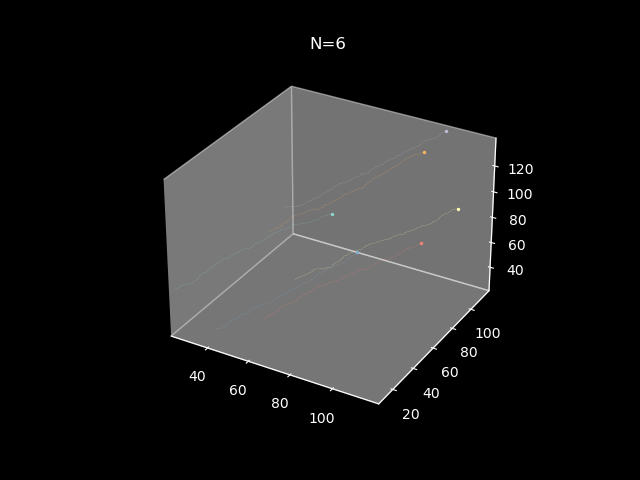

In [6]:
animate_inter('testpos_3D', 3, 30, True, 'test_lines')

In [7]:
def plot(file, dim, name='trajectories', lim =None, dpi=300):
    """
    This function takes a txt file where the lines contains the timesteps and the positions of the N partilces at that timestep and plots the trajectories of the particles in 2D or 3D.
    
    Parameters
    -----------------------------
    file
        The txt file containing the times teps and positions
        The input needs to have the form: t  x_1  y_1  z_1 ... x_N  y_N  z_N
    dim
        Dimension of the Nbody simulation, has to be 2 or 3
    name
        Name of the plot
    lim
        An array with the axis limits
    dpi
        DPI of the image
    
    Output
    -----------------------------
    Creates a png file plotting the trajectories of the N particles.
    """
    t, traj = trajectories(file, dim)
    n_t = len(traj)
    N = len(traj[0])
    fig = plt.figure()
    if dim == 2:
        x = np.zeros((N, n_t))
        y = np.zeros((N, n_t))
        for i in range(N):
            for j in range(n_t):
                x[i][j] = traj[j][i][0]
                y[i][j] = traj[j][i][1]
        ax = fig.add_subplot(111)
        ax.set_title('N={}'.format(N))
        ax.set_xlim(lim[0][0], lim[0][1])
        ax.set_ylim(lim[1][0], lim[1][1])
        ax.grid(False)
        for i in range(N):
            ax.plot(x[i],y[i])
        plt.savefig('{}_2D.png'.format(name), dpi=dpi)

    if dim == 3:
        x = np.zeros((N, n_t))
        y = np.zeros((N, n_t))
        z = np.zeros((N, n_t))
        for i in range(N):
            for j in range(n_t):
                x[i][j] = traj[j][i][0]
                y[i][j] = traj[j][i][1]
                z[i][j] = traj[j][i][2]
        ax = fig.add_subplot(projection='3d')
        ax.set_title('N={}'.format(N))
        ax.set_xlim3d(lim[0][0], lim[0][1])
        ax.set_ylim3d(lim[1][0], lim[1][1])
        ax.set_zlim3d(lim[2][0], lim[2][1])
        for i in range(N):
            ax.plot(x[i],y[i], z[i])
        plt.savefig('{}_3D.png'.format(name), dpi=dpi)

In [8]:
# animate_inter('three_body_motion_RK2_2D', 2, 300)

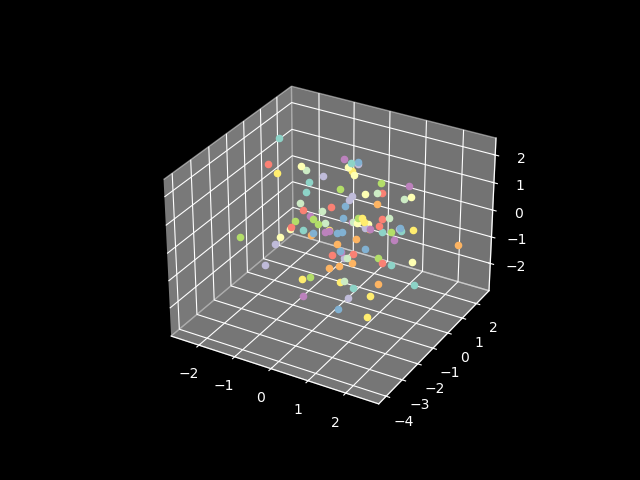

In [9]:
pos = np.random.randn(100, 3)
vel = np.random.randn(100, 3)

with open('100gauss.txt', 'w') as d:
        for t in range(100):
            d.write('1 {} {} {} {} {} {}\n'.format(pos[t][0], pos[t][1], pos[t][2], vel[t][0], vel[t][1], vel[t][2]))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(100):
    ax.scatter(pos[i][0], pos[i][1], pos[i][2])
plt.show()